In [1]:
import numpy as np
import xarray as xr
import pickle
import pandas as pd
import time
import os

from collections import OrderedDict

import datetime
from sys import getsizeof,path

import matplotlib.pyplot as plt
import matplotlib

path.append("../src")
from Splines import CentripetalCatmullRomSpline_splitControls,Spline
import Cases
from Population import ImportPopulation
from ModelParams import ObservedData,ModelParam



In [2]:
matplotlib.rcParams['figure.figsize'] = [12, 6]

In [3]:
df = pd.read_csv("../Data/Deaths/COVID-19_Todesfaelle_10y_210930.csv",sep=";",na_values="<4")
df = df.fillna(2).astype("int64")
df.index = range(10,len(df)+10)

f = {"AG 90+ Jahre":90}
for i in range(9):
    f["AG %d-%d Jahre"%(i*10,i*10+9)] = i*10

week_of_death = df.rename(columns=f)
print(week_of_death)

    Sterbejahr  Sterbewoche  0  10  20  30  40  50   60   70   80   90
10        2020           10  0   0   0   0   0   2    2    0    0    0
11        2020           11  0   0   0   0   0   0    2    6   11    0
12        2020           12  0   0   0   0   2   8    7   36   85   25
13        2020           13  0   0   2   2   7  19   60  143  294   74
14        2020           14  0   0   2   5   9  55  127  320  592  260
..         ...          ... ..  ..  ..  ..  ..  ..  ...  ...  ...  ...
85        2021           32  0   0   0   2   2   2   10   16   26   15
86        2021           33  2   0   2   2   5  10   17   30   44   15
87        2021           34  2   0   0   2   6   8   25   36   54   25
88        2021           35  0   0   0   5  14  22   31   45   80   43
89        2021           36  0   2   2   2  17  24   36   59   92   56

[80 rows x 12 columns]


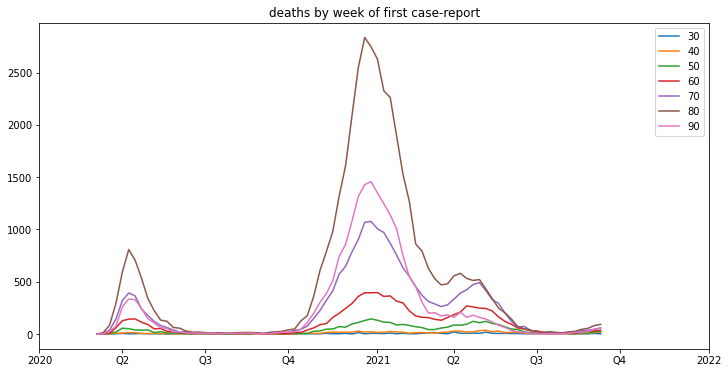

In [4]:
week_of_death.filter([30,40,50,60,70,80,90]).plot()
plt.xticks([1,14,27,40,54,66,79,92,53*2],labels=[2020,"Q2","Q3","Q4",2021,"Q2","Q3","Q4",2022])
_ = plt.title("deaths by week of first case-report")

    Meldejahr  Meldewoche   0   5   15    35    60    80
10       2020          10   2   3   23    85    37    11
11       2020          11   2   2   54   238   152    77
12       2020          12  14   6  152   725   861   472
13       2020          13  32  16  259  1359  2217  1259
14       2020          14  27  17  305  1346  2488  1920
..        ...         ...  ..  ..  ...   ...   ...   ...
87       2021          34  84  67  615  1265   593   351
88       2021          35  73  66  568  1166   662   433
89       2021          36  89  78  505  1050   695   491
90       2021          37  72  51  400   810   541   446
91       2021          38  54  48  258   482   437   329

[82 rows x 8 columns]


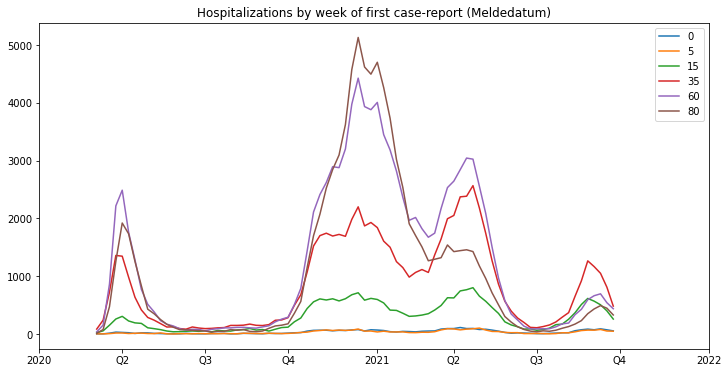

In [5]:
df = pd.read_csv("../Data/Cases/SitRep_RKI/Hospitalisierung_Altersverteilung_210930.csv",sep=";",header=4)
#df = df.astype("int64")

f = {"Fälle A00..04":0,"Fälle A05..14":5,"Fälle A15..34":15,"Fälle A35..59":35,"Fälle A60..79":60,"Fälle A80+":80}
df = df.rename(columns=f)
df.index = range(10,len(df)+10)
meldedatum_hospitalization = df.filter(["Meldejahr","Meldewoche"]+list(f.values())).fillna(0).astype("int64")

meldedatum_hospitalization.filter([0,5,15,35,60,80]).plot()
plt.xticks([1,14,27,40,54,66,79,92,53*2],labels=[2020,"Q2","Q3","Q4",2021,"Q2","Q3","Q4",2022])
plt.title("Hospitalizations by week of first case-report (Meldedatum)")

print(meldedatum_hospitalization)

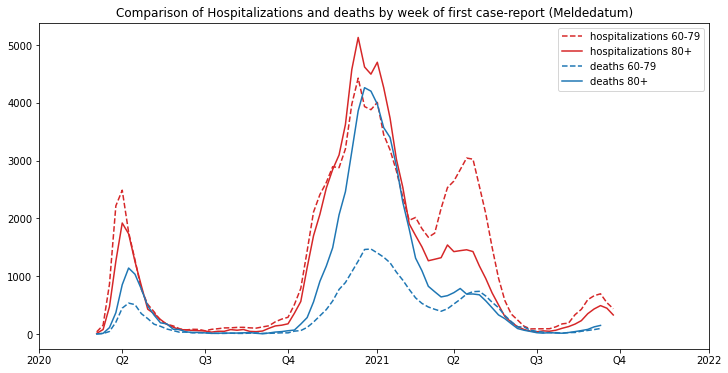

In [6]:
plt.plot(meldedatum_hospitalization.filter([60]),"--",color="tab:red",label="hospitalizations 60-79")
plt.plot(meldedatum_hospitalization.filter([80]),color="tab:red",label="hospitalizations 80+")

plt.plot(week_of_death[60]+week_of_death[70],"--",color="tab:blue",label="deaths 60-79")
plt.plot(week_of_death[80]+week_of_death[90],color="tab:blue",label="deaths 80+")
#plt.plot(week_of_death.filter([80]),color="tab:blue")
plt.title("Comparison of Hospitalizations and deaths by week of first case-report (Meldedatum)")
plt.legend()
_ = plt.xticks([1,14,27,40,54,66,79,92,53*2],labels=[2020,"Q2","Q3","Q4",2021,"Q2","Q3","Q4",2022])

In [7]:
path.append("../Data/Deaths/SitRep_RKI")
from CopiedData import DeathsPerAG

In [8]:
# cuml. reportet death at each tuesday
DeathsPerAG()

4224 Datapoints


<xarray.DataArray (date: 192, sex: 2, age: 11)>
array([[[    0,     1,     3, ...,  1399,   376,     3],
        [    1,     0,     2, ...,  1206,   643,    32]],

       [[    0,     1,     4, ...,  1437,   382,     4],
        [    1,     0,     2, ...,  1250,   658,    32]],

       [[    0,     1,     4, ...,  1479,   390,     4],
        [    1,     0,     2, ...,  1296,   689,    33]],

       ...,

       [[    4,     6,    57, ..., 20873,  6651,     0],
        [   11,     6,    33, ..., 20148, 12803,     0]],

       [[    4,     6,    60, ..., 20929,  6675,     0],
        [   11,     6,    36, ..., 20202, 12840,     0]],

       [[    4,     6,    62, ..., 21022,  6704,     0],
        [   11,     6,    36, ..., 20283, 12876,     0]]], dtype=int32)
Coordinates:
  * age      (age) int64 0 10 20 30 40 50 60 70 80 90 100
  * sex      (sex) <U6 'male' 'female'
  * date     (date) object 2020-04-27 2020-04-28 ... 2021-09-21 2021-09-28

In [9]:
df = pd.read_csv("../Data/Cases/RKI_COVID19_210930.csv",sep=",",parse_dates=["Meldedatum","Refdatum"])
df = df.filter(["Altersgruppe","Geschlecht","AnzahlFall","AnzahlTodesfall","Meldedatum","Refdatum","IstErkrankungsbeginn"])


In [10]:
n = 110
ages = OrderedDict()
for k,v in zip(("A00-A04","A05-A14","A15-34","A35-A59","A60-A79","A80+"),(0,5,15,35,60,80)):
    ages[k] = v
data = np.zeros((n,2,len(ages),2,),dtype="int64")

weeks = pd.date_range("2019-12-30", periods=n, freq="W-MON")
for i,w1,w2 in zip(range(0,n),weeks[:-1],weeks[1:]):
    wmask = (df["Meldedatum"] >= w1) & (df["Meldedatum"] < w2)
    if True:#i == 20:
        cases_in_week = df[wmask]
        for j,sex in enumerate(["M","W"]):
            cases_in_week_sex = cases_in_week[cases_in_week["Geschlecht"]==sex]
            for k,age in enumerate(ages.keys()):
                cases_in_week_sex_age = cases_in_week_sex[cases_in_week_sex["Altersgruppe"]==age]
                cases,deaths = cases_in_week_sex_age["AnzahlFall"].sum(),cases_in_week_sex_age["AnzahlTodesfall"].sum()
                data[i,j,k] = [cases,deaths]

cases = xr.DataArray(data,dims=["week","sex","age","status"],coords={"week":range(1,n+1),"sex":["M","W"],"age":list(ages.values()),"status":["cases","deaths"]})


In [11]:
meldedatum_hospitalization[60].sum()
cases.sum("sex").sel(age=60,status="cases",week=range(10,92))

<xarray.DataArray (week: 82)>
array([  123,   924,  3671,  6895,  7664,  5258,  3228,  2185,  1293,
        1024,   687,   496,   437,   270,   228,   311,   270,   250,
         253,   287,   356,   396,   470,   453,   523,   531,   554,
         858,  1217,  1341,  1788,  3047,  5229,  9628, 15027, 17285,
       17453, 18129, 17765, 19148, 23920, 28396, 24218, 21906, 24973,
       19851, 16274, 13497, 10959,  8348,  8577,  8827,  8320,  9644,
       12751, 15506, 15418, 16644, 18793, 18208, 15702, 12762,  8749,
        6105,  3095,  2030,  1234,   586,   377,   345,   364,   463,
         617,   901,  1045,  1632,  2232,  3312,  4077,  4362,  4057,
        3845])
Coordinates:
  * week     (week) int64 10 11 12 13 14 15 16 17 18 ... 84 85 86 87 88 89 90 91
    age      int64 60
    status   <U6 'cases'

In [12]:
meldedatum_hospitalization[60]

10      37
11     152
12     861
13    2217
14    2488
      ... 
87     593
88     662
89     695
90     541
91     437
Name: 60, Length: 82, dtype: int64

In [13]:
df = pd.read_csv("../Data/ICU/DIVI/bund-altersstruktur-zeitreihe_210930.csv",sep=",",parse_dates=["Datum"],index_col=["Datum"])
df.index = df.index.tz_convert(None)
df = df.resample("W-MON").max()
df = df[df["Stratum_Unbekannt"]<200]
startweek = df.index[0].week+53
df.index = range(startweek,startweek+len(df))
f = OrderedDict()
f["Stratum_17_Minus"] = 0
f["Stratum_18_Bis_29"] = 18
f["Stratum_30_Bis_39"] = 30
f["Stratum_40_Bis_49"] = 40
f["Stratum_50_Bis_59"] = 50
f["Stratum_60_Bis_69"] = 60
f["Stratum_70_Bis_79"] = 70
f["Stratum_80_Plus"] = 80
week_icu_max = df.rename(columns=f).filter(f.values())

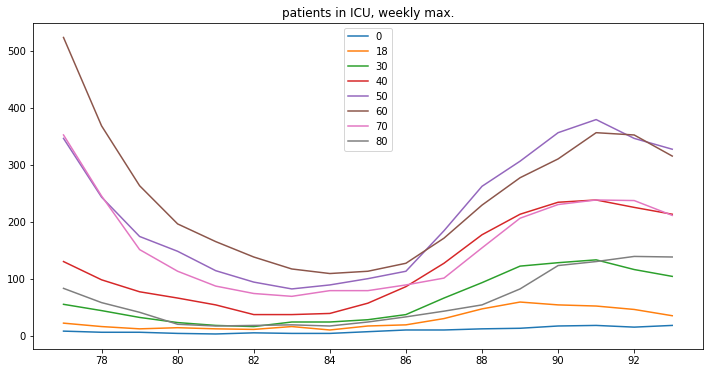

In [14]:
week_icu_max.plot()
_ = plt.title("patients in ICU, weekly max.")

AgeGroup starting 35 until week 91


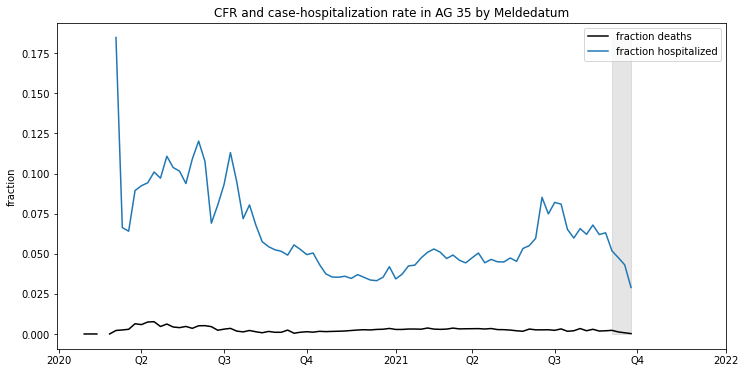

In [25]:
# Change to generate different plots
age = 35

lastweek = meldedatum_hospitalization.index[-1]
print("AgeGroup starting",age,"until week",lastweek)
c = cases.sum("sex").sel(age=age,week=range(1,lastweek+1))
plt.plot(c.coords["week"],c.sel(status="deaths")/c.sel(status="cases"),color="black",label="fraction deaths")
frac_hospital = meldedatum_hospitalization[age]/c.sel(status="cases",week=range(10,92))

plt.plot(range(10,92),frac_hospital,color="tab:blue",label="fraction hospitalized")

plt.fill_between([lastweek-3,lastweek],[0,0],[np.max(frac_hospital)]*2,alpha=.2,color="grey")

plt.xticks([1,14,27,40,54,66,79,92,53*2],labels=[2020,"Q2","Q3","Q4",2021,"Q2","Q3","Q4",2022])
plt.title("CFR and case-hospitalization rate in AG %d by Meldedatum"%age)
plt.ylabel("fraction")
plt.savefig("plots/fraction_AG%d.pdf"%age)
_ = plt.legend()

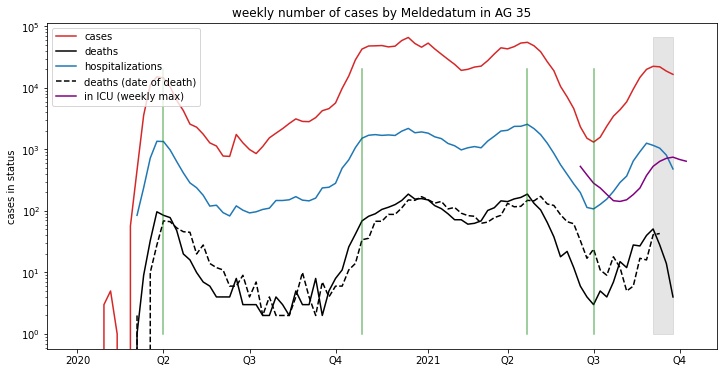

In [26]:
plt.semilogy(range(1,lastweek+1),cases.sum("sex").sel(age=age,status="cases",week=range(1,lastweek+1)),color="tab:red",label="cases")
plt.semilogy(range(1,lastweek+1),cases.sum("sex").sel(age=age,status="deaths",week=range(1,lastweek+1)),color="black",label="deaths")
plt.semilogy(meldedatum_hospitalization[age],color="tab:blue",label="hospitalizations")
if age == 80:
    wod = week_of_death[80]+week_of_death[90]
    icu = week_icu_max[80]
elif age == 60:
    wod = week_of_death[60]+week_of_death[70]
    icu = week_icu_max[60]+week_icu_max[70]
elif age == 35:
    wod = week_of_death[30]+week_of_death[40]+week_of_death[50]
    icu = week_icu_max[40]+week_icu_max[50]+week_icu_max[30]
plt.semilogy(range(10,90),wod,"k--",label="deaths (date of death)")
plt.semilogy(icu.index,icu,"purple",label="in ICU (weekly max)")
plt.xticks([1,14,27,40,54,66,79,92,53*2],labels=[2020,"Q2","Q3","Q4",2021,"Q2","Q3","Q4",2022])
plt.fill_between([wod.index[-2],wod.index[-1]+2],[1,1],[np.max(cases.sum("sex").sel(age=age))]*2,alpha=.2,color="grey")
for x in [14,79,69,44]:
    plt.plot([x,x],[1,20000],"-",alpha=.5,color="green")
plt.legend()
plt.ylabel("cases in status")
plt.title("weekly number of cases by Meldedatum in AG %d"%age)
plt.savefig("plots/casesAndStatus_AG%d.pdf"%age)